# Compute and compare prediction scores across different rankings (on a fine grained level)

### Imports

In [16]:

import numpy as np
import sys
import os

sys.path.append('..')
# Add the project root directory
sys.path.append(os.path.abspath("./../../rule_based"))  # or the absolute path to your project
sys.path.append(os.path.abspath("./../../explainer"))  # or the absolute path to your project



# import util_scripts.stats_utils as su
# import util_scripts.analysis_utils as au
import compare_rankings as cr

from rule_based.rule_dataset import RuleDataset
from tgb.linkproppred.evaluate import Evaluator
from rule_based.eval import evaluate
import rule_based.rule_utils as rule_utils

from tqdm import tqdm

import json

import matplotlib.cm as cm


## User Input

In [17]:
dataset_name =  'tkgl-icews14'
if dataset_name == 'tkgl-icews14':
    p_value = 30
else:
    p_value = 1
rankings_filename = f'{dataset_name}-rankings_test_conf_0_corr_conf_0_noisyor_crules_frules_zrules_pvalue_{p_value}_num_top_rules_10_multi_decay0.8.txt'  # replace with name of your rankings file - 
# you can generate rankings using the counttrucola main.py. it will be stored in files/rankings/dataset_name/
# you can also use your own rankings file, as long as it is in the same format
# rankings format example:
# 25 13 ? 337
# 15 0.8158242432096148 44 0.5658675347599267 87 0.2962600387521216 ...

eval_mode ='test'
path_rankings_test = os.path.join('..', 'rankings', dataset_name, rankings_filename) # path to the rankings file.





## Figures and Stats

### 1. Compute some basic dataset stats

### 2. Evaluation Part 1: Compute the MRR, e.g. MRR per relation of CountTRuCoLa

In [18]:
## read dataset and compute some stats
dataset =  RuleDataset(name=dataset_name)
# stats_df, num_triples_dict, rel_df = su.compute_stats(dataset_name, dataset)

raw file found, skipping download
Dataset directory is  /home/jgasting/counttrucola/tgb/datasets/tkgl_icews14
loading processed file
num_rels:  230
>>> loading and indexing of dataset 6.327 seconds
>>> average number of time steps for a triple: 1.804
>>> checked order of time steps, everything is fine


In [19]:
explanations_path = os.path.join('./', 'b_better_explanations.txt')
rule_dataset = RuleDataset(name=dataset_name)
dataset = rule_dataset.dataset
num_nodes = rule_dataset.dataset.num_nodes
split_mode = eval_mode
evaluation_mode = eval_mode
evaluator = Evaluator(name=dataset.name, k_value=[1,10,100])
neg_sampler = dataset.negative_sampler  

if evaluation_mode == "val":
    testdata = rule_dataset.val_data
    print("loading negative val samples")
    dataset.load_val_ns() # load negative samples, i.e. the nodes that are not used for time aware filter mrr
elif evaluation_mode == "test":
    testdata = rule_dataset.test_data
    print("loading negative test samples")
    dataset.load_test_ns() # load negative samples, i.e. the nodes that are not used for time aware filter mrr

rankings_rules = rule_utils.read_rankings(path_rankings_test)


b_better ={}

print('>>> starting evaluation for every triple, in the ', evaluation_mode, 'set')
total_iterations = len(testdata)
progressbar_percentage = 0.01

i_list = []
increment=1000
remaining = total_iterations
mrr_per_rel = {}
hit1_per_rel = {}


mrr_per_rel_brules = {}
hit1_per_rel_brules = {}

list_scores = []
hits1_scores = []
bins_dict = {}
bins_dict[0] = [0,0] # total, correct
for c in range(11):
    b = c-1
    bins_dict[float(b/10)] = [0,0] # total, correct


with open(explanations_path, 'w') as filebetter:


    counter = 0
    filebetter.write("src\trel\tdst\tt\correct\thighest_rank\n") #header
    for head in rule_dataset.head_rel_t_tail['test']:
        for rel in rule_dataset.head_rel_t_tail['test'][head]:
            for t in rule_dataset.head_rel_t_tail['test'][head][rel]:
                tails = rule_dataset.head_rel_t_tail['test'][head][rel][t]

                original_t = rule_dataset.timestamp_id2orig[t]

                # Query negative batch list - all negative samples for the given positive edge that are not temporal conflicts (time aware mrr)
                src = head
                dst = tails[0]
                neg_batch_list = neg_sampler.query_batch(np.array([src]), np.array([dst]), np.array([original_t]), edge_type=np.array([rel]), split_mode=split_mode)

                # Compute a score for each node in neg_batch_list and for actual correct node dst
                scores_array =rule_utils.create_scores_array(rankings_rules[(src, rel, t)], num_nodes)
                predictions_neg= scores_array[neg_batch_list[0]]
                predictions_pos = {}
                for tail in tails:
                    
                    dst = tail                     
                                # Make predictions for given src, rel, t
                    predictions_pos[dst] = scores_array[dst]
                

                # all wrong predictions
                for score in predictions_neg:
                    if score > 0:
                        for c in range(11):
                            b = c
                            if score > b/10 and score <= (b+1)/10:
                                bins_dict[float(b/10)][0] += 1
                        
                # all correct predictions
                for score in predictions_pos.values():
                    for c in range(11):
                        b = c
                        if score > b/10 and score <= (b+1)/10:
                            bins_dict[float(b/10)][0] += 1
                            bins_dict[float(b/10)][1] += 1
                counter += 1
                if counter % increment == 0:
                    print(f'Progress: {counter}/{total_iterations} ({(counter/total_iterations)*100:.2f}%)')
print('bins_dict:')
print(bins_dict)

rankings_name = os.path.splitext(os.path.basename(path_rankings_test))[0]
out_path = os.path.join('./', rankings_name + '.json')

with open(out_path, 'w') as f:
    json.dump(bins_dict, f, indent=2)

print("Saved bins_dict to", out_path)

raw file found, skipping download
Dataset directory is  /home/jgasting/counttrucola/tgb/datasets/tkgl_icews14
loading processed file
num_rels:  230
>>> loading and indexing of dataset 5.288 seconds
>>> average number of time steps for a triple: 1.804
>>> checked order of time steps, everything is fine
loading negative test samples
>>> starting evaluation for every triple, in the  test set
Progress: 1000/14742 (6.78%)
Progress: 2000/14742 (13.57%)
Progress: 3000/14742 (20.35%)
Progress: 4000/14742 (27.13%)
Progress: 5000/14742 (33.92%)
Progress: 6000/14742 (40.70%)
Progress: 7000/14742 (47.48%)
Progress: 8000/14742 (54.27%)
Progress: 9000/14742 (61.05%)
Progress: 10000/14742 (67.83%)
Progress: 11000/14742 (74.62%)
Progress: 12000/14742 (81.40%)
Progress: 13000/14742 (88.18%)
bins_dict:
{0: [13987905, 4448], -0.1: [0, 0], 0.1: [159749, 2039], 0.2: [36738, 1465], 0.3: [11443, 1065], 0.4: [5056, 904], 0.5: [2774, 745], 0.6: [1732, 695], 0.7: [1314, 640], 0.8: [965, 617], 0.9: [697, 568]}
S

new_bins_dict (total, correct, accuracy):
{0: (13987905, 4448, 0.00031798900550153864), 0.1: (159749, 2039, 0.012763773169159118), 0.2: (36738, 1465, 0.03987696662855898), 0.3: (11443, 1065, 0.0930699991261033), 0.4: (5056, 904, 0.1787974683544304), 0.5: (2774, 745, 0.2685652487382841), 0.6: (1732, 695, 0.40127020785219397), 0.7: (1314, 640, 0.487062404870624), 0.8: (965, 617, 0.6393782383419689), 0.9: (697, 568, 0.8149210903873745)}


/tmp/ipykernel_523543/974381472.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("viridis", N)


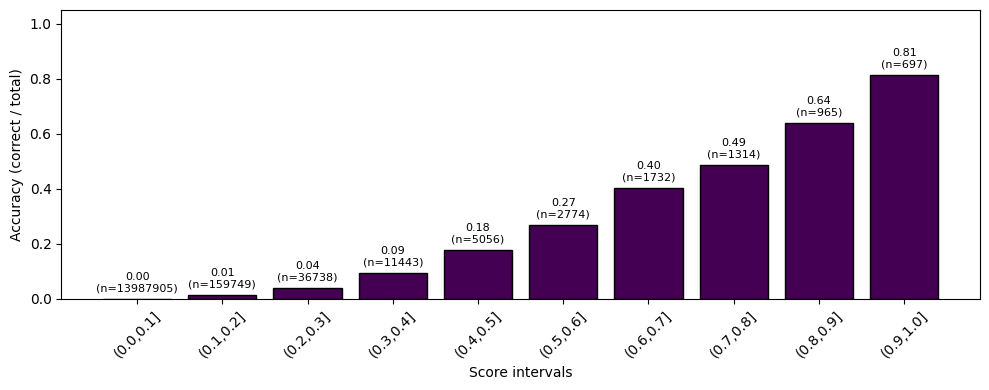

In [20]:
new_bins_dict = {}
for b in bins_dict:
    total = bins_dict[b][0]
    correct = bins_dict[b][1]
    if total > 0:
        accuracy = correct/total
        new_bins_dict[b] = (total, correct, accuracy)
    else:
        accuracy = 0
N=5
colors = cm.get_cmap("viridis", N)
color_list = [colors(i) for i in range(N)]
color = color_list[0]   # number in [0, 1]

print('new_bins_dict (total, correct, accuracy):')
print(new_bins_dict)

import matplotlib.pyplot as plt

sorted_keys = sorted(new_bins_dict.keys())
accuracies = [new_bins_dict[k][2] for k in sorted_keys]
totals = [new_bins_dict[k][0] for k in sorted_keys]

fig, ax = plt.subplots(figsize=(10,4))
x = range(len(sorted_keys))
ax.bar(x, accuracies, color=color, edgecolor='k')
ax.set_xticks(x)
ax.set_xticklabels([f"({float(k):.1f},{float(k+0.1):.1f}]" for k in sorted_keys], rotation=45)
ax.set_xlabel('Score intervals')
ax.set_ylabel('Accuracy (correct / total)')
# ax.set_title('Accuracy per score bin (sorted by bin key)')

for i, (acc, tot) in enumerate(zip(accuracies, totals)):
    ax.text(i, acc + 0.02, f"{acc:.2f}\n(n={tot})", ha='center', va='bottom', fontsize=8)

ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.savefig(rankings_name + '_accuracy_per_bin.png')
plt.savefig(rankings_name + '_accuracy_per_bin.pdf')
plt.show()

In [ ]:
explanations_path = os.path.join('./', 'b_better_explanations.txt')

split_mode = eval_mode
evaluation_mode = eval_mode
evaluator = Evaluator(name=dataset.name, k_value=[1,10,100])
neg_sampler = dataset.negative_sampler  



if evaluation_mode == "val":
    testdata = rule_dataset.val_data
    print("loading negative val samples")
    dataset.load_val_ns() # load negative samples, i.e. the nodes that are not used for time aware filter mrr
elif evaluation_mode == "test":
    testdata = rule_dataset.test_data
    print("loading negative test samples")
    dataset.load_test_ns() # load negative samples, i.e. the nodes that are not used for time aware filter mrr

rankings_rules = rule_utils.read_rankings(path_rankings_test)



b_better ={}

print('>>> starting evaluation for every triple, in the ', evaluation_mode, 'set')
total_iterations = len(testdata)
progressbar_percentage = 0.01

i_list = []
increment=1000
remaining = total_iterations
mrr_per_rel = {}
hit1_per_rel = {}


mrr_per_rel_brules = {}
hit1_per_rel_brules = {}

list_scores = []
hits1_scores = []
bins_dict = {}
bins_dict[0] = [0,0] # total, correct
for c in range(11):
    b = c-1
    bins_dict[float(b/10)] = [0,0] # total, correct

hits1_list = np.zeros(len(testdata))
scores_list = np.zeros(len(testdata))
scores_list_filter = np.zeros(len(testdata))
with tqdm(total=total_iterations) as pbar:
    counter = 0
    for i, (src, dst, t, rel) in enumerate(zip(testdata[:,0], testdata[:,2], testdata[:,3], testdata[:,1])):
        # Update progress bar
        
        if counter % increment == 0:
            remaining -= increment
            pbar.update(increment)
        if remaining < increment:
            pbar.update(remaining)

        original_t = rule_dataset.timestamp_id2orig[t]

        # Query negative batch list - all negative samples for the given positive edge that are not temporal conflicts (time aware mrr)


        neg_batch_list = neg_sampler.query_batch(np.array([src]), np.array([dst]), np.array([original_t]), edge_type=np.array([rel]), split_mode='test')

        # Compute a score for each node in neg_batch_list and for actual correct node dst
        scores_array =rule_utils.create_scores_array(rankings_rules[(src, rel, t)], num_nodes)
        predictions_neg= scores_array[neg_batch_list[0]]
        predictions_pos = np.array(scores_array[dst])

        scores_filter = np.append(predictions_neg, predictions_pos)

        scores_list[counter] = np.max(scores_array)
        scores_list_filter[counter] = np.max(scores_filter)

                    # Evaluate the predictions
        input_dict = {
            "y_pred_pos": predictions_pos,
            "y_pred_neg": predictions_neg,
            "eval_metric": ['mrr'], 
        }

        predictions = evaluator.eval(input_dict)

        hits1_list[i] = float(predictions['hits@1'])
        counter += 1

hits1 = float(np.mean(hits1_list))

print('mean hits1:', np.mean(hits1_list))

print('mean highest score:', np.mean(scores_list))
print('mean highest filtered score:', np.mean(scores_list_filter))

loading negative test samples
>>> starting evaluation for every triple, in the  test set


565564it [00:04, 114457.90it/s]                        

mean hits1: 0.3590421923755257
mean highest score: 0.4223096275428342
mean highest filtered score: 0.4104877682204043
